In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
import numpy as np


In [2]:
# Read the data
df = pd.read_csv('datasets/Spotify_YoutubeClean.csv')
df = df.set_index('id')
df = df.dropna()

# Drop columns that are not needed
df = df.drop(['Views', 'Likes', 'Comments','Stream'], axis=1)

In [3]:
# Separate features X and target y
X = df.drop('Popularity', axis=1)
y = df['Popularity']

In [4]:
# One-hot encoding of categorical variables
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(X[['Album_type', 'Licensed', 'official_video']])

# Create DataFrame with one-hot encoded columns
one_hot_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(['Album_type', 'Licensed', 'official_video']))

# Reset index of both DataFrames
X = X.reset_index(drop=True)
one_hot_df = one_hot_df.reset_index(drop=True)

# Concatenate one-hot encoded columns with original DataFrame
X_encoded = pd.concat([X, one_hot_df], axis=1)

# Drop original categorical columns
X_encoded = X_encoded.drop(['Album_type', 'Licensed', 'official_video'], axis=1)


In [5]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [6]:
# Define parameter grid for my hyperparameter tuning
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# Perform grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Create RF with best parameters
rf_classifier = RandomForestClassifier(random_state=42, **grid_search.best_params_)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report)


Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Accuracy: 0.5867007672634271
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.36      0.42       806
           1       0.64      0.65      0.64      1116
           2       0.57      0.66      0.61      1612
           3       0.67      0.56      0.61       376

    accuracy                           0.59      3910
   macro avg       0.59      0.56      0.57      3910
weighted avg       0.58      0.59      0.58      3910



In [7]:
# Define evaluation metric
scoring = make_scorer(balanced_accuracy_score)

# Perform stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_classifier, X_encoded, y, cv=cv, scoring=scoring)

print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())




Cross-Validation Scores: [0.5719463  0.54758876 0.5583687  0.55607375 0.57754311]
Mean Cross-Validation Score: 0.562304123395087


                   feature  importance
11       Artist_Popularity    0.212111
10             Duration_ms    0.079722
3                 Loudness    0.074937
5             Acousticness    0.067852
0             Danceability    0.067328
1                   Energy    0.067185
4              Speechiness    0.066982
8                  Valence    0.066879
9                    Tempo    0.066541
7                 Liveness    0.064652
6         Instrumentalness    0.048919
2                      Key    0.040138
17    official_video_False    0.021767
18     official_video_True    0.016093
15          Licensed_False    0.010973
16           Licensed_True    0.010426
14       Album_type_single    0.007821
12        Album_type_album    0.006978
13  Album_type_compilation    0.002696


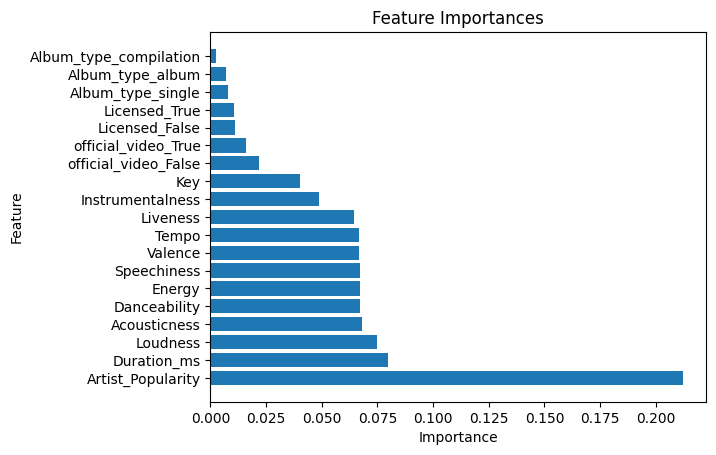

Best Parameters: {'max_depth': None, 'n_estimators': 200}
Threshold: 0.01
Accuracy: 0.5867007672634271
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.38      0.43       806
           1       0.63      0.65      0.64      1116
           2       0.57      0.65      0.61      1612
           3       0.66      0.58      0.62       376

    accuracy                           0.59      3910
   macro avg       0.59      0.57      0.58      3910
weighted avg       0.58      0.59      0.58      3910

Best Parameters: {'max_depth': 30, 'n_estimators': 200}
Threshold: 0.02
Accuracy: 0.5818414322250639
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.36      0.41       806
           1       0.64      0.65      0.64      1116
           2       0.57      0.65      0.61      1612
           3       0.64      0.57      0.60       376

    accuracy                           0.

In [8]:
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_classifier.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a DataFrame to store the feature importances
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values('importance', ascending=False)

# Display the DataFrame
print(importance_df)

# Create a bar chart to visualize feature importances (to do further feature selection)
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# Set the range of threshold values to try
thresholds = [0.01, 0.02, 0.03, 0.04, 0.05]

# Loop over the threshold values
for threshold in thresholds:
    # Create a mask to select only the features with importance greater than or equal to the threshold
    mask = importances >= threshold

    # Apply the mask to the feature names to get the selected features
    selected_features = feature_names[mask]

    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30]
    }

    # Perform grid search using only the selected features
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
    grid_search.fit(X_train[selected_features], y_train)

    # Print best parameters
    print("Best Parameters:", grid_search.best_params_)

    # Create RF with best parameters
    rf_classifier = RandomForestClassifier(random_state=42, **grid_search.best_params_)

    # Retrain the model using only the selected features
    rf_classifier.fit(X_train[selected_features], y_train)

    # Predict on the test set using only the selected features
    y_pred = rf_classifier.predict(X_test[selected_features])

    # Evaluate the performance of the new model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Threshold:", threshold)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
